In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x10b83e4c0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.ndimage as ndi
import skimage.morphology as morph
import skimage.util
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
def blend_result(img, seg, border_radius=1, interior_opacity=1, interior_opacity_decay=0.9, color=(0,1,0)):
    img  = numpy.dstack([img] * 3).copy()
    img -= img.min()
    img /= img.max()
    selem  = morph.disk(border_radius)
    seg_bd = logical_xor(morph.binary_dilation(seg, selem), morph.binary_erosion(seg, selem))
    mask_decay = ndi.distance_transform_edt(seg)
    for i in range(3):
        opacity = interior_opacity / pow(1 + mask_decay[seg], interior_opacity_decay)
        img[:,:,i][seg] = color[i] * opacity + (1 - opacity) * img[:,:,i][seg]
        img[:,:,i][seg_bd] = color[i]
    return img

In [4]:
patch_sizes = (32, 32)

---

**Task 1.1.** Implement `create_data_matrix`:

In [5]:
def create_data_matrix(img):
    blocks = skimage.util.view_as_blocks(img, patch_sizes)
    matrix = blocks.reshape(numpy.prod(blocks.shape[:2]), -1)
    return matrix

**Task 1.2.** Implement `create_gt_labels_vector`:

In [6]:
def create_gt_labels_vector(gt):
    blocks   = skimage.util.view_as_blocks(gt, patch_sizes)
    portions = blocks.sum(axis=(2,3)) / numpy.prod(patch_sizes)
    labels   = numpy.zeros(portions.shape[:2], int)
    labels[portions >  0.5] = +1
    labels[portions == 0.0] = -1
    vector = labels.reshape(-1)
    return vector

**Task 1.3.** Create the SVM classifier:

In [7]:
clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', gamma=0.1))

**Task 1.3.a.** Create the data matrices for the images `dna-33` and `dna-44`:

In [8]:
X33 = create_data_matrix(imread('../data/NIH3T3/im/dna-33.png'))
X44 = create_data_matrix(imread('../data/NIH3T3/im/dna-44.png'))

In [9]:
X33.shape

(1344, 1024)

**Task 1.3.b.** Create the corresponding ground truth label vectors:

In [10]:
Y33 = create_gt_labels_vector(imread('../data/NIH3T3/gt/33.png').astype(bool))
Y44 = create_gt_labels_vector(imread('../data/NIH3T3/gt/44.png').astype(bool))

**Task 1.3.c.** Create the *combined* data matrices and ground truth label vectors:

In [11]:
X = numpy.concatenate([X33, X44], axis=0)
Y = numpy.concatenate([Y33, Y44], axis=0)

X = X[Y != 0]
Y = Y[Y != 0]

**Task 1.3.d.** Train the classifier using the data matrix and label vectors from above:

In [12]:
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma=0.1))])

**Task 1.4.** Implement the function `predict_image`:

In [13]:
def predict_image(img):
    X = create_data_matrix(img)
    Y = clf.predict(X)
    result = numpy.zeros(img.shape, bool)
    blocks = skimage.util.view_as_blocks(result, patch_sizes)
    Y = Y.reshape(blocks.shape[:2])
    blocks[Y == +1] = True
    return result

Test your implementation:

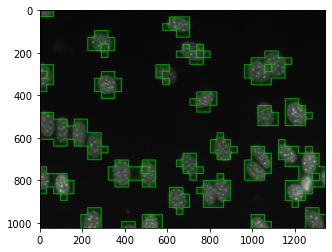

In [14]:
img = imread(f'../data/NIH3T3/im/dna-0.png')
seg = predict_image(img)

figure()
imshow(blend_result(img, seg))

**Task 1.5.** Perform batch processing:

In [15]:
def compute_dice(bin1, bin2):
    assert bin1.dtype == numpy.bool
    assert bin2.dtype == numpy.bool
    dice = 2 * (bin1 * bin2).sum() / (bin1.sum() + bin2.sum())
    return dice

dices = []
for i in [28,29,33,44,46,49]:
    img = imread(f'../data/NIH3T3/im/dna-{i}.png')
    gt  = imread(f'../data/NIH3T3/gt/{i}.png').astype(bool)
    seg = predict_image(img)
    dice = compute_dice(seg, gt)
    dices.append(dice)
    print(f'Image: {i}, Dice: {dice:.2f}')
print(f'\nAverage Dice: {mean(dices):.2f}')

Image: 28, Dice: 0.72
Image: 29, Dice: 0.66
Image: 33, Dice: 0.68
Image: 44, Dice: 0.71
Image: 46, Dice: 0.62
Image: 49, Dice: 0.69

Average Dice: 0.68
